# Imports and Defaults

In [1]:
import wandb
import polars as pl
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [17]:
sns.set_theme(style="darkgrid")

# Download Data

In [12]:
api = wandb.Api()
entity, project = "gilad-turok", "dr-funnel"
sweeps = ["w7ezsclk", "xi8r0nom", "4ucaxa3g"]
runs = api.runs(entity + "/" + project, filters={"sweep": {"$in": sweeps}})

run_data = []
for run in runs:
    run_data.append(
        {k:v for k, v in run.summary._json_dict.items() if not isinstance(v, dict)} | {k: v for k, v in run.config.items() if not k.startswith("_")} | {"name": run.name, "group": run.group, "sweep": str(run.sweep)}
    )
runs_df = pl.DataFrame(run_data)

# Squared Error

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


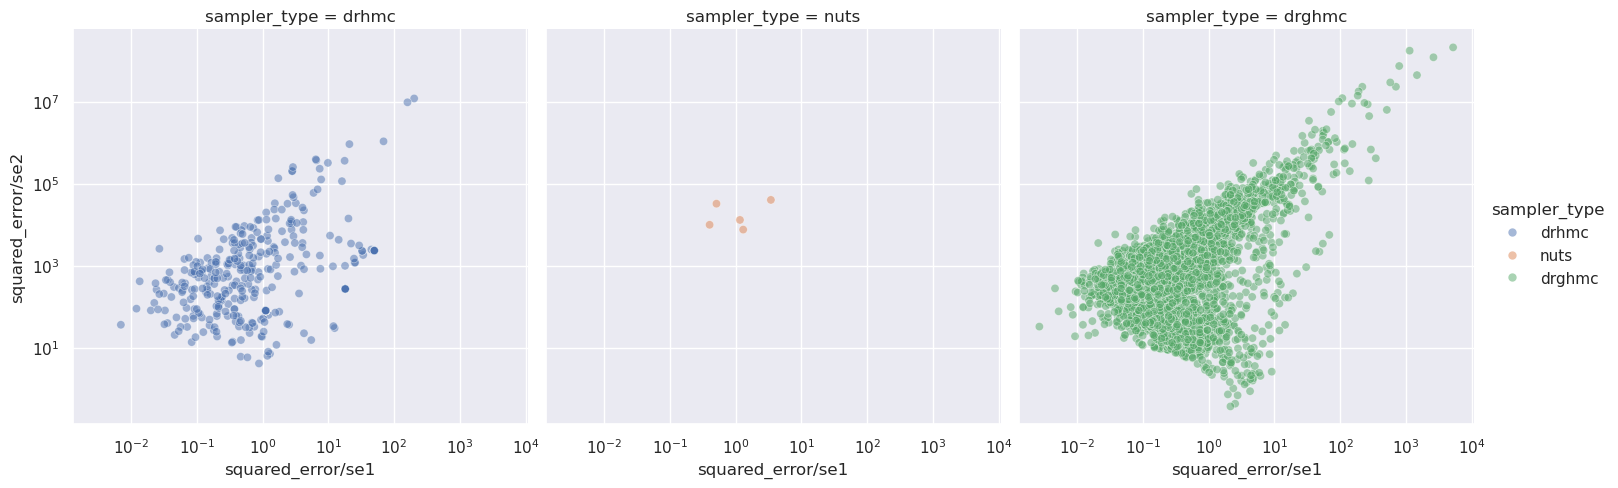

In [35]:
fig = sns.relplot(kind="scatter", data=runs_df, x="squared_error/se1", y="squared_error/se2", col="sampler_type", marker="o", alpha=0.5, hue="sampler_type")
fig.set(xscale="log", yscale="log")

In [24]:
# group by the "group" column, then compute the average "squared_error/se1" and "squared_error/se2" for each group
# keep the other columns the same
grouped = runs_df.group_by("group").agg([
    pl.col("squared_error/se1").mean().alias("se1_mean"),
    pl.col("squared_error/se2").mean().alias("se2_mean"),
    pl.col("squared_error/se1").std().alias("se1_std"),
    pl.col("squared_error/se2").std().alias("se2_std"),
    pl.col("sampler_type").first().alias("sampler_type"),
    # pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("se1_std") > pl.col("se2_std")).then(pl.col("se1_std")).otherwise(pl.col("se2_std")).alias("max_std")
)
grouped.head()

group,se1_mean,se2_mean,se1_std,se2_std,sampler_type,step_count_factor,max_proposals,reduction_factor,damping,max_std
str,f64,f64,f64,f64,str,f64,i64,i64,i64,f64
"""drghmc__step_c…",1.572834,7938.123547,1.64348,6439.969859,"""drghmc""",null,5,2,0,6439.969859
"""drghmc__step_c…",0.602676,144.893501,0.574746,186.510976,"""drghmc""",null,5,16,0,186.510976
"""drghmc__step_c…",0.63764,1056.817875,0.583506,941.132033,"""drghmc""",null,4,4,0,941.132033
"""drghmc__step_c…",0.327217,2001.92208,0.229956,1701.405684,"""drghmc""",null,5,4,0,1701.405684
"""drghmc__step_c…",0.923554,4622.843331,1.384706,6429.78115,"""drghmc""",null,2,4,0,6429.78115


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


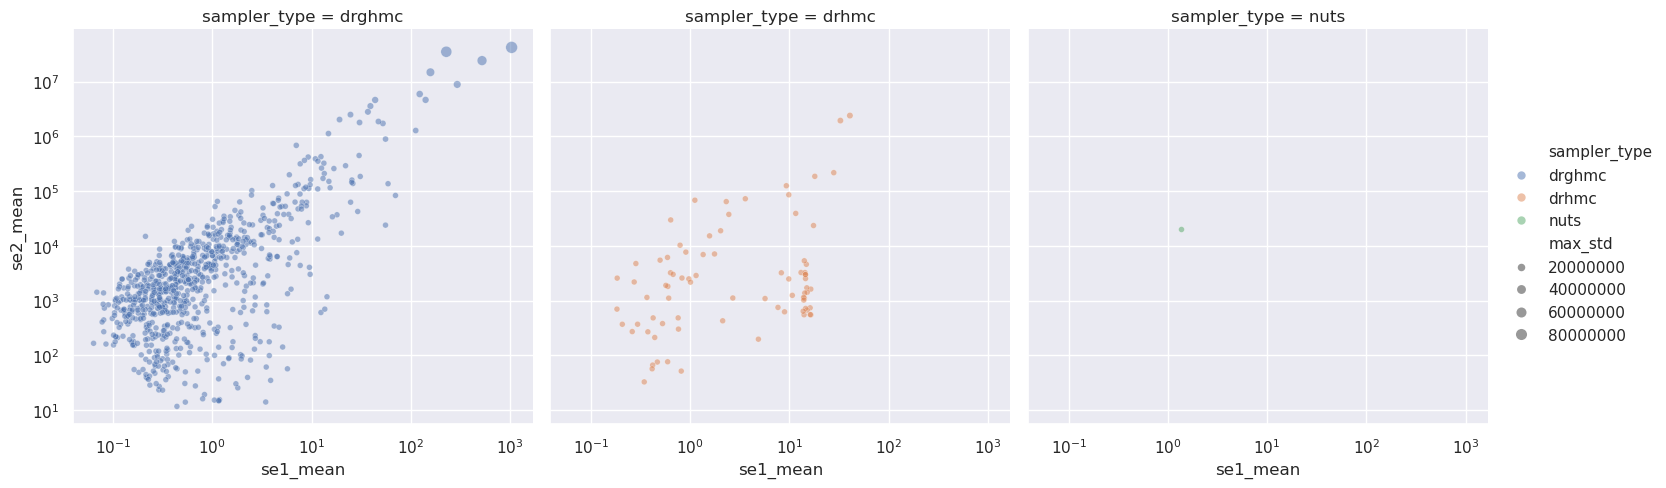

In [25]:
fig = sns.relplot(kind="scatter", data=grouped, x="se1_mean", y="se2_mean", col="sampler_type", marker="o", alpha=0.5, hue="sampler_type", size="max_std",)
fig.set(xscale="log", yscale="log")

# Relative Squared Error

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Relative Squared Error')

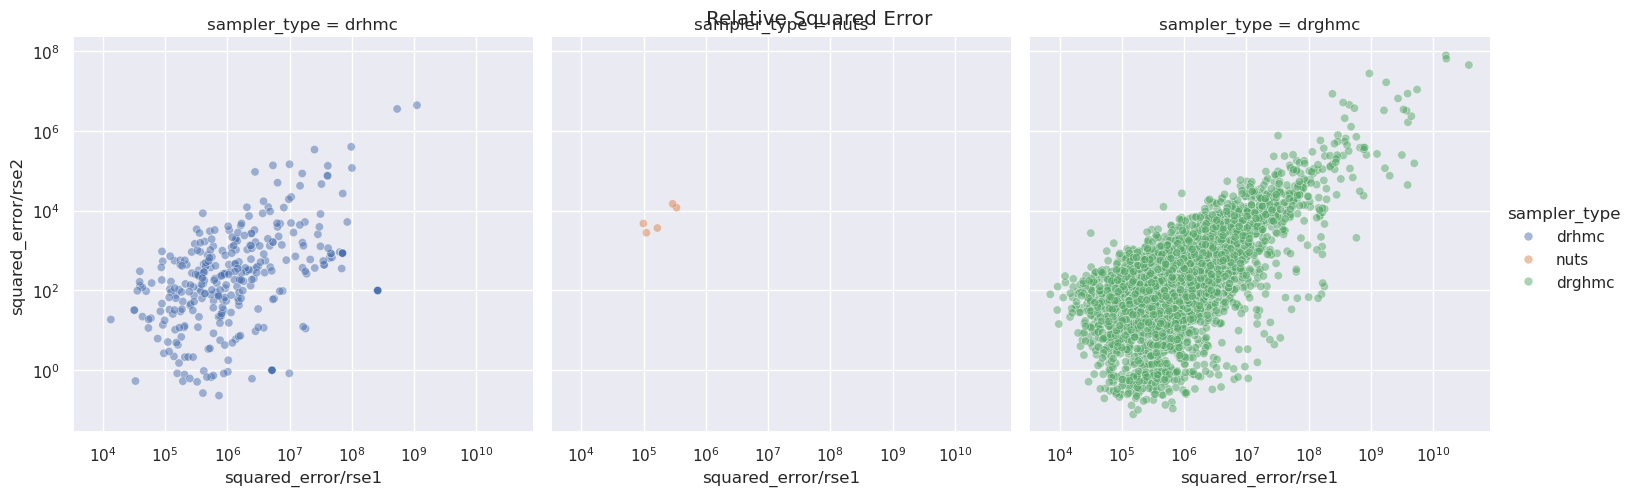

In [31]:
fig = sns.relplot(kind="scatter", data=runs_df, x="squared_error/rse1", y="squared_error/rse2", col="sampler_type", marker="o", alpha=0.5, hue="sampler_type")
fig.set(xscale="log", yscale="log")
fig.fig.suptitle("Relative Squared Error")

In [32]:
# group by the "group" column, then compute the average "squared_error/se1" and "squared_error/se2" for each group
# keep the other columns the same
grouped = runs_df.group_by("group").agg([
    pl.col("squared_error/rse1").mean().alias("rse1_mean"),
    pl.col("squared_error/rse2").mean().alias("rse2_mean"),
    pl.col("squared_error/rse1").std().alias("rse1_std"),
    pl.col("squared_error/rse2").std().alias("rse2_std"),
    pl.col("sampler_type").first().alias("sampler_type"),
    # pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("rse1_std") > pl.col("rse2_std")).then(pl.col("rse1_std")).otherwise(pl.col("rse2_std")).alias("max_std")
)
grouped.head()

group,rse1_mean,rse2_mean,rse1_std,rse2_std,sampler_type,step_count_factor,max_proposals,reduction_factor,damping,max_std
str,f64,f64,f64,f64,str,f64,i64,i64,i64,f64
"""drghmc__step_c…",629054.879993,380.144339,534528.876857,251.108423,"""drghmc""",null,4,2,0,534528.876857
"""drghmc__step_c…",269573.676243,124.435798,329316.685794,116.194555,"""drghmc""",null,4,4,0,329316.685794
"""drghmc__step_c…",544160.768605,0.497295,355404.98697,0.32467,"""drghmc""",null,4,16,0,355404.98697
"""drghmc__step_c…",977979.791379,724.473279,398200.207393,722.075011,"""drghmc""",null,3,16,0,398200.207393
"""drghmc__step_c…",794942.697931,637.532485,927543.760718,1325.978398,"""drghmc""",null,4,4,0,927543.760718


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


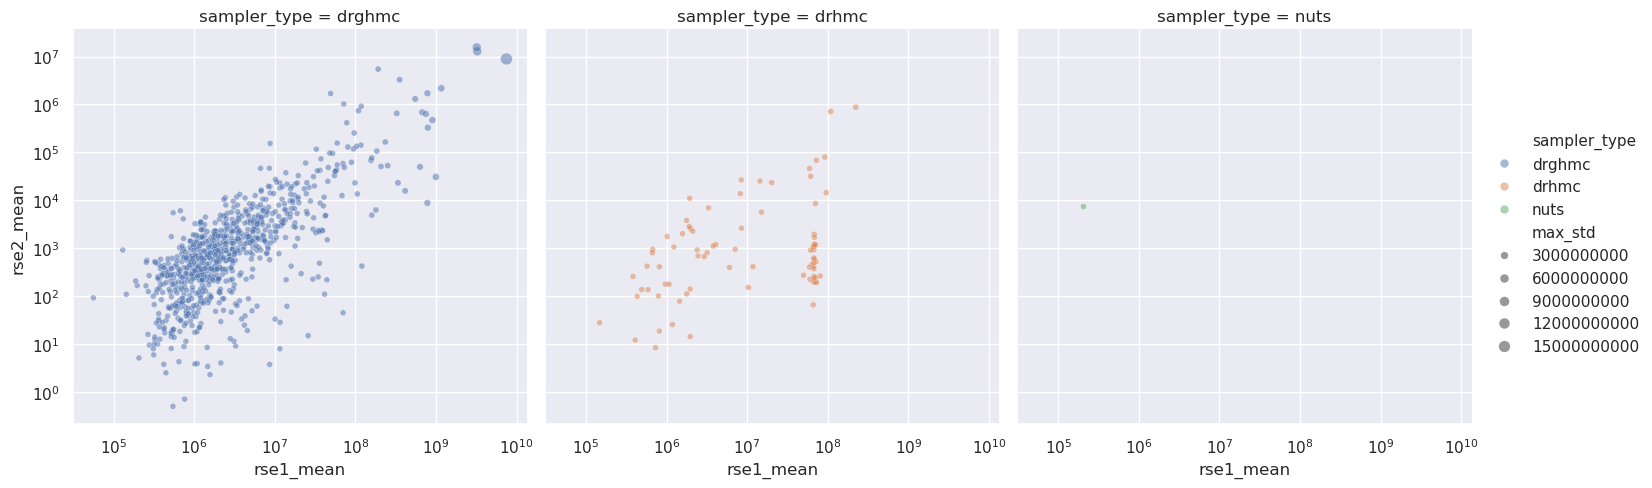

In [34]:
fig = sns.relplot(kind="scatter", data=grouped, x="rse1_mean", y="rse2_mean", col="sampler_type", marker="o", alpha=0.5, hue="sampler_type", size="max_std",)
fig.set(xscale="log", yscale="log")

# Other

In [14]:
desired_groups = ["nuts"]
api = wandb.Api()
entity, project = "gilad-turok", "dr-funnel"

# filter to runs that have their runs.group set to one of the desired groups
runs = api.runs(entity + "/" + project, filters={"group": {"$in": desired_groups}})
runs = runs[:5]

In [27]:
run_data = []
for run in runs:
    hyper_param_dict = {k:v for k, v in run.summary._json_dict.items() if not isinstance(v, dict)} | {k: v for k, v in run.config.items() if not k.startswith("_")} | {"name": run.name, "group": run.group}
    history = run.history(keys=["se1_wandb", "se2_wandb"], x_axis="grad_evals")
    # for every key, value in hyper_param_dict, add a column to history datframe
    for k, v in hyper_param_dict.items():
        history[k] = [v] * len(history)
runs_df = pl.DataFrame(run_data)

<class 'pandas.core.frame.DataFrame'>
grad_evals


TypeError: unsupported operand type(s) for |: 'dict' and 'str'